In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from glob import glob
import pickle

from PIL import ImageColor
import matplotlib.colors

from utils import FEATURES_DIR, RESULTS_DIR, SUBJECTS, NUM_TEST_STIMULI
from analyses.ridge_regression_decoding import NUM_CV_SPLITS, DECODER_OUT_DIR, calc_rsa, calc_rsa_images, calc_rsa_captions, get_fmri_data, pairwise_accuracy, ACC_MODALITY_AGNOSTIC, ACC_CAPTIONS, ACC_IMAGES, get_default_features, get_default_vision_features, MOD_SPECIFIC_IMAGES, MOD_SPECIFIC_CAPTIONS
from notebook_utils import add_avg_subject, create_result_graph, plot_metric_catplot, plot_metric, load_results_data, ACC_MEAN

# Zero-shot cross-modal decoding

In [12]:
all_data = load_results_data()

100%|██████████| 201/201 [00:02<00:00, 70.55it/s]


In [13]:
MODEL_ORDER = ["random-flava", "clip", "flava", "imagebind", "blip2"]

all_data = all_data[all_data.model.isin(MODEL_ORDER)]
all_data

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
8,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.872143,clip_avg
9,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.862653,clip_avg
10,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.924286,clip_avg
11,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.893469,clip_avg
12,100000.0,clip,sub-01,concat,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.875918,clip_concat
...,...,...,...,...,...,...,...,...,...,...,...
679,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_mean,0.832959,flava_matched
680,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.817653,imagebind_matched
681,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.737347,imagebind_matched
682,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939388,imagebind_matched


In [14]:
data_default_vision_feats = all_data.copy()
for model in all_data.model.unique():
    default_vision_feats = get_default_vision_features(model)
    data_default_vision_feats = data_default_vision_feats[((data_default_vision_feats.model == model) & (data_default_vision_feats.vision_features == default_vision_feats)) | (data_default_vision_feats.model != model)]
    
data_default_vision_feats

Selected default vision features for clip: visual_feature_cls
Selected default vision features for flava: visual_feature_cls
Selected default vision features for imagebind: visual_feature_cls


,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
8,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.872143,clip_avg
9,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.862653,clip_avg
10,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.924286,clip_avg
11,100000.0,clip,sub-01,avg,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.893469,clip_avg
12,100000.0,clip,sub-01,concat,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.875918,clip_concat
...,...,...,...,...,...,...,...,...,...,...,...
679,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_mean,0.832959,flava_matched
680,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.817653,imagebind_matched
681,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.737347,imagebind_matched
682,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939388,imagebind_matched


In [15]:
data_matched_feats = data_default_vision_feats[data_default_vision_feats.features == "matched"]
data_matched_feats

,alpha,model,subject,features,vision_features,training_mode,mask,num_voxels,metric,value,model_feat
16,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.860510,clip_matched
17,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_captions,0.857551,clip_matched
18,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_images,0.918163,clip_matched
19,100000.0,clip,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_mean,0.887857,clip_matched
48,100000.0,flava,sub-01,matched,visual_feature_cls,modality-agnostic,whole_brain,162649,pairwise_acc_modality_agnostic,0.877143,flava_matched
...,...,...,...,...,...,...,...,...,...,...,...
679,100000.0,flava,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_mean,0.832959,flava_matched
680,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_modality_agnostic,0.817653,imagebind_matched
681,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_captions,0.737347,imagebind_matched
682,100000.0,imagebind,sub-07,matched,visual_feature_cls,images,whole_brain,214739,pairwise_acc_images,0.939388,imagebind_matched


In [16]:
# add oks/zero_shot_cross_modal_de #TODO not necessary?!
extra_rows = []
for model in data_matched_feats.model.unique():
    for subject in SUBJECTS:
        data_model_subj = data_matched_feats[(data_matched_feats.model == model) & (data_matched_feats.subject == subject)]
        # cross-modal
        cross_modal_train_images_eval_captions = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_CAPTIONS)]
        cross_modal_train_captions_eval_images = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_IMAGES)]

        if len(cross_modal_train_images_eval_captions) > 0:
            assert len(cross_modal_train_images_eval_captions) == len(cross_modal_train_captions_eval_images) == 1
            mean_acc = (cross_modal_train_images_eval_captions.value.item() + cross_modal_train_captions_eval_images.value.item()) / 2
    
            mean_row = cross_modal_train_images_eval_captions.copy()
            mean_row["training_mode"] = "cross-modal"
            mean_row["metric"] = "mean"
            mean_row["value"] = mean_acc
            mean_row["condition"] = "cross-modal"

            extra_rows.append(mean_row)

        # within-modal
        within_modal_captions = data_model_subj[(data_model_subj.training_mode == "captions") & (data_model_subj.metric == ACC_CAPTIONS)]
        within_modal_images = data_model_subj[(data_model_subj.training_mode == "images") & (data_model_subj.metric == ACC_IMAGES)]

        if len(within_modal_captions) > 0:
            assert len(within_modal_captions) == len(within_modal_images) == 1
            mean_acc = (within_modal_captions.value.item() + within_modal_images.value.item()) / 2
    
            mean_row = within_modal_captions.copy()
            mean_row["training_mode"] = "within-modal"
            mean_row["metric"] = "mean"
            mean_row["value"] = mean_acc
            mean_row["condition"] = "within-modal"

            extra_rows.append(mean_row)

extra_rows = pd.concat(extra_rows)
data_matched_with_mean = pd.concat((data_matched_feats, extra_rows), ignore_index=True)
# data_matched_with_mean[data_matched_with_mean.metric == "mean"]

In [17]:
DEFAULT_FEAT_OPTIONS = ["vision", "lang", "matched"]

def calc_model_feat_order(data, feat_options=DEFAULT_FEAT_OPTIONS):
    all_model_feats = data.model_feat.unique()
    all_models = data.model.unique()
    for model in all_models:
        if model not in MODEL_ORDER:
            raise RuntimeError(f"Model missing in order: {model}")
    model_feat_order = []
    for model in MODEL_ORDER:
        for feats in feat_options:
            model_feat = f"{model}_{feats}"
            if model_feat in all_model_feats:
                model_feat_order.append(model_feat)

    return model_feat_order

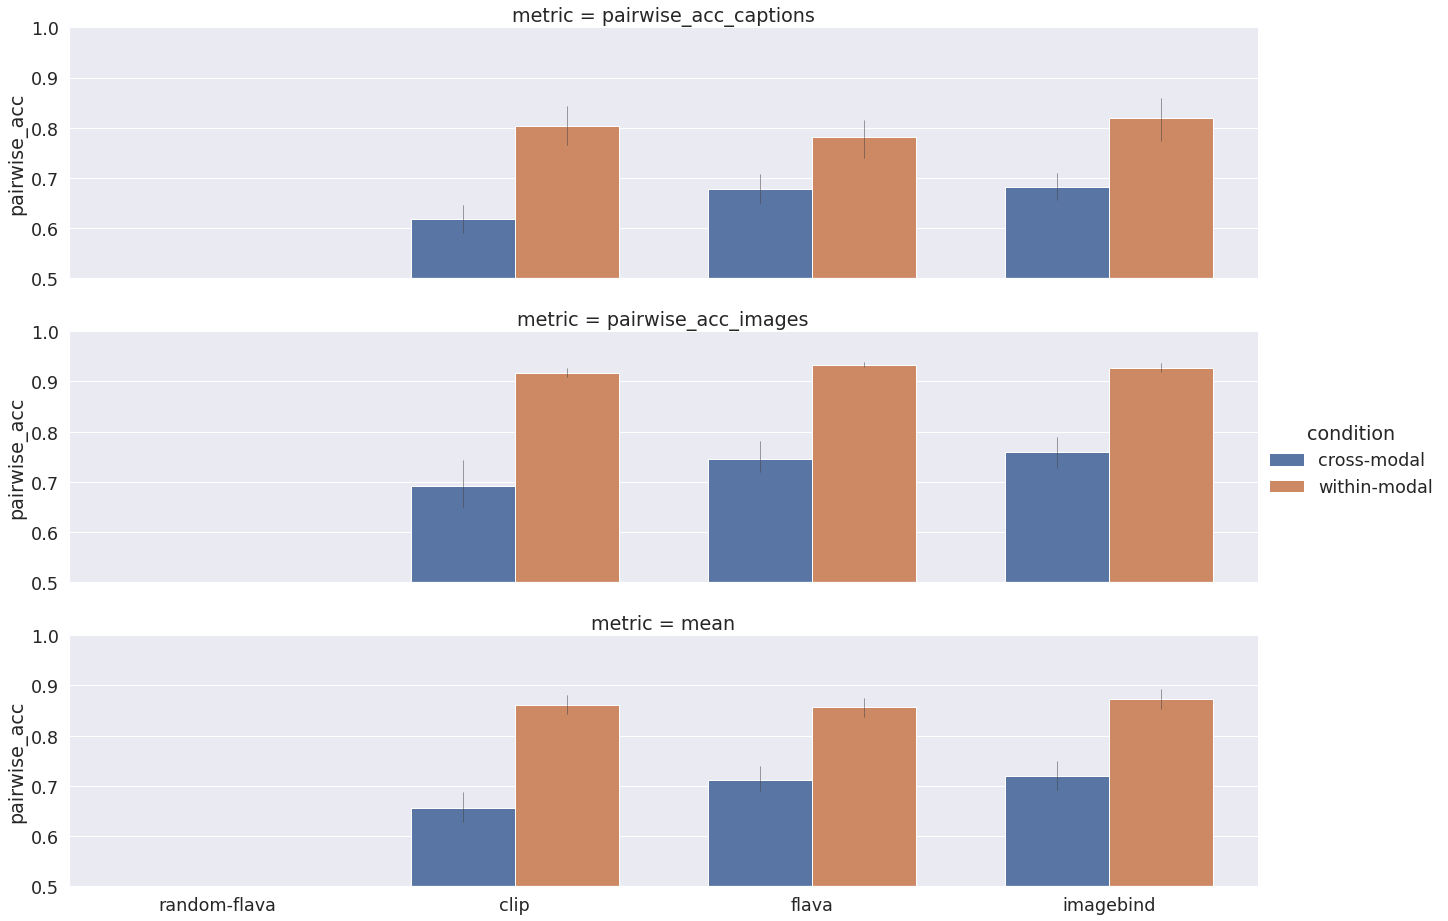

In [18]:
sns.set(font_scale=1.6)
TRAIN_MODE_ORDER = ["images", "captions", "modality-agnostic"]
FEAT_ORDER = ["vision models", "language models", "multimodal models"]

data_to_plot = data_matched_with_mean.copy()

data_to_plot = data_to_plot[data_to_plot.training_mode != "modality-agnostic"]

data_to_plot["features"] = data_to_plot.features.replace({"vision": "vision models", "lang": "language models", "matched": "multimodal models"})

data_to_plot.loc[((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "cross-modal"
data_to_plot.loc[((data_to_plot.training_mode == "captions") & (data_to_plot.metric == ACC_CAPTIONS)) | ((data_to_plot.training_mode == "images") & (data_to_plot.metric == ACC_IMAGES)), "condition"] = "within-modal"

data_to_plot = data_to_plot[data_to_plot["mask"] == "whole_brain"]
model_feat_order = calc_model_feat_order(data_to_plot)

# data_to_plot["metric"] = data_to_plot.metric.replace({ACC_CAPTIONS: "zero_shot_train_images_eval_captions", ACC_IMAGES: "zero_shot_train_captions_eval_images"})


metrics_order = [ACC_CAPTIONS, ACC_IMAGES, "mean"]

height = 4.5
aspect = 4

condition_order = ["cross-modal", "within-modal"]

for mode in ["captions", "images", "cross-modal", "within-modal"]:
    data_mode = data_to_plot[data_to_plot.training_mode == mode]
    for model in MODEL_ORDER:
        for condition in condition_order:
            length = len(data_mode[(data_mode.model == model) & (data_mode.condition == condition)])
            expected_num_datapoints = len(SUBJECTS)
            if (length > 0) and (length != expected_num_datapoints):
                message = f"unexpected number of datapoints: {length} (expected: {expected_num_datapoints}) (model_feat: {model} {mode})"
                print(f"Warning: {message}")
            
g = sns.catplot(data_to_plot, kind="bar", x="model", order=MODEL_ORDER, y="value", row="metric", row_order=metrics_order, col=None, height=height, aspect=aspect, hue="condition", hue_order=condition_order,
                palette=None, err_kws={'linewidth': 0.5, 'alpha': 0.99}, width=0.7)
   
g.set(ylim=(0.5, 1), ylabel="pairwise_acc", xlabel='')





# figure, lgd = create_result_graph(data_to_plot, model_feat_order, metrics=metrics_order, row_order=metrics_order, hue_order=FEAT_ORDER, ylim=(0.5, 1), row_title_height=0.85,
#                              legend_bbox=(0.06,0.98), legend_2_bbox=(0.99,0.98), height=4.5, legend_title="Modality-agnostic decoders projecting into feature space of", verify_num_datapoints=False)
# plt.savefig(os.path.join(RESULTS_DIR, f"features_comparison_zero_shot_cross_modal_decoding.png"), bbox_extra_artists=(lgd,), bbox_inches='tight', pad_inches=0, dpi=300)
